In [1]:
import qunum.numerical as qn
from qunum.jupyter_tools import *
from qunum.jupyter_tools.plotting import *
import torch
from sympy import *
setup_plotly()
from torch.autograd import grad
import numpy as np

In [2]:
t = torch.linspace(0,10, 1000).reshape(1000,1)
def L(X,t):
    x = X(t)
    D = qn.D_Op(der_dims = 0)

    dx = D(x,t)
    ddx = D(dx,t)
    
    return  torch.pow((ddx + dx + 100*x), 2).sum() +( 1/((x**2).sum()))
t = t.requires_grad_(True)

In [38]:

class GeneralHarmonicSolution(torch.nn.Module):
    def __init__(self):
        super(GeneralHarmonicSolution, self).__init__()
        self.w = torch.nn.Sequential(
            torch.nn.Linear(1,1, bias= False),
        )
        self.tau = torch.nn.Sequential(
            torch.nn.Linear(1,1, bias = False),
        )
        
        pass
    
    def forward(self, t):
        return self(t)
    def __call__(self, t):
        return torch.cos(self.w(t))*torch.exp(-self.tau(t))
    

X = GeneralHarmonicSolution()

Ll = qn.seml.data.lazy_sampler_init(num_sample=100, Dists = [qn.math_.random.distributions.SquareNormal(0, 5)], shps=[1],num_batches=10)
O = (
    torch.optim.Adam(X.parameters(), lr=.9),
    torch.optim.LBFGS(X.parameters(), lr = 1e-1)
)
G = qn.seml.GradDescentTrain(X, L, O, device = 'cpu', loss_args=('Model', 'x'), dataLoader=Ll, epochs = 1000, stop_threshold=1e-1)
X

GeneralHarmonicSolution(
  (w): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
  )
  (tau): Sequential(
    (0): Linear(in_features=1, out_features=1, bias=False)
  )
)

39it [00:00, 77.28it/s]


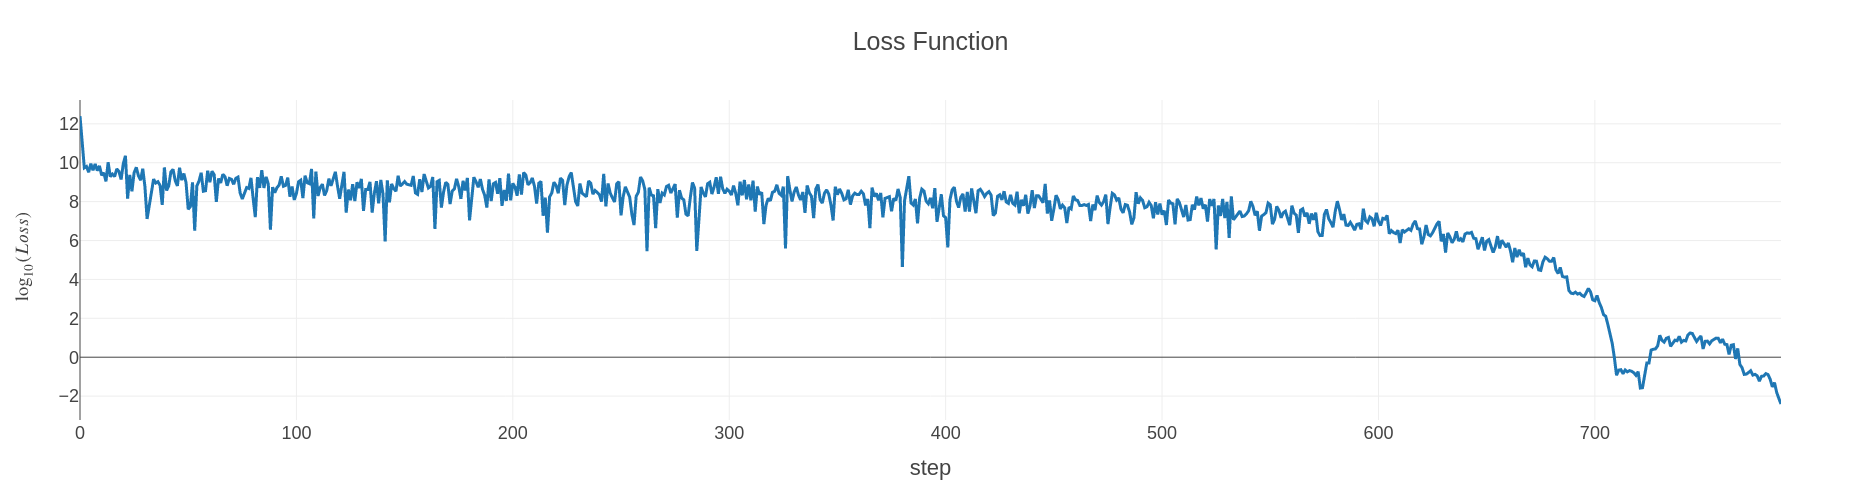

In [39]:
iplot(G.train(epochs =200).plot_fun().update_yaxes(title='$\\log_{10}(Loss)$'))


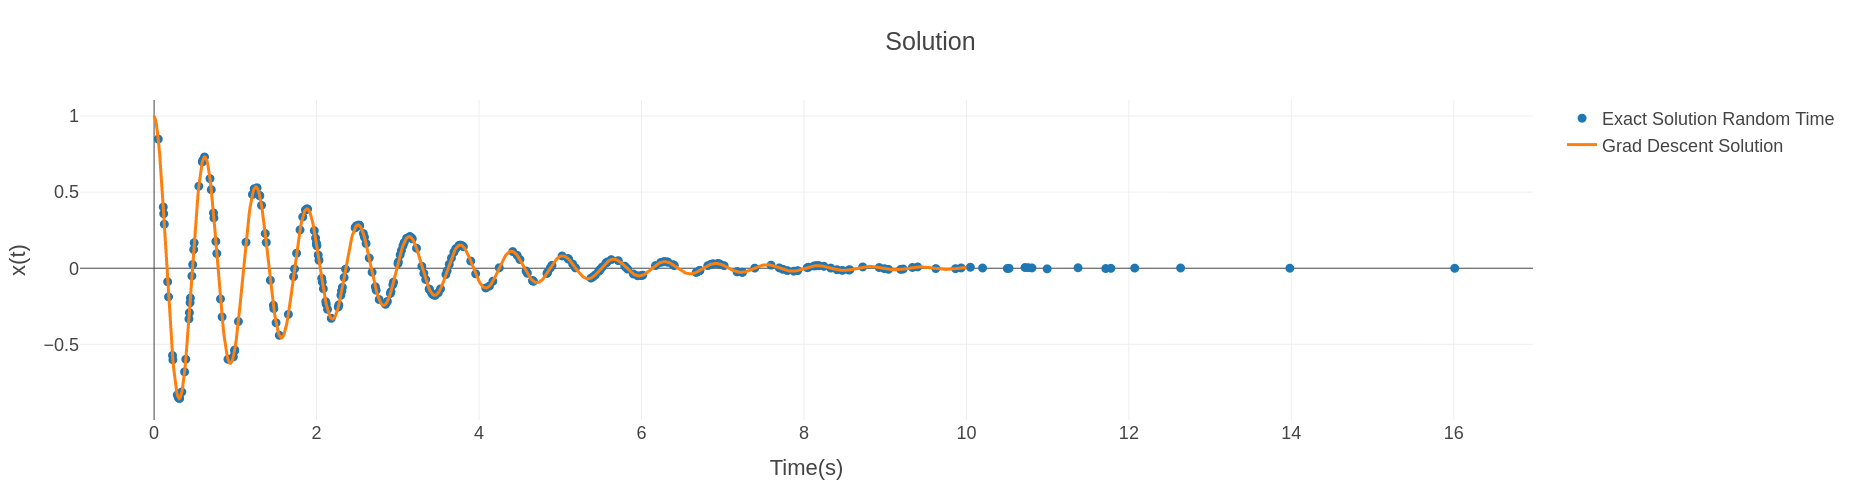

In [43]:
a = torch.complex(torch.tensor([1.**2 - 4*100]) , torch.tensor([0.0]))
w = (-1. - torch.sqrt(a))/2
x = t.detach()
xr = Ll.sampleit(250)[0].detach()[:,0]
fig = go.Figure(data = [{
        'type':'scatter',
        'x':xr,
        'y':torch.exp( w*xr ).real[:].detach(),
        'name':'Exact Solution Random Time',
        'mode':'markers'
    },
    {
        'type':'scatter',
        'x':x[:,0],
        'y':X(x).detach()[:,0],
        'name':'Grad Descent Solution'
}
],layout={'height':500, 'width':1250, 'title':'Solution', 'xaxis':{'title':'Time(s)'}, 'yaxis':{'title':'x(t)'}})
iplot(fig)